In [1]:
import sys

import numpy as np
import astropy.units as u
import astropy.wcs
from astropy.coordinates import SkyCoord
import astropy.constants as const
import ndcube
from scipy.io import readsav
import sunpy.map
from astropy.visualization import ImageNormalize, LogStretch, SqrtStretch, quantity_support
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import readsav
import distributed

from synthesizAR.atomic.idl import read_spectral_table
from synthesizAR.instruments.physical import InstrumentDEM
from synthesizAR.instruments.util import extend_celestial_wcs

from overlappy.util import hgs_observer_to_keys, pcij_to_keys, color_lat_lon_axes
from overlappy.wcs import pcij_matrix
from overlappy.reproject import reproject_to_overlappogram

sys.path.append('../../')
from mocksipipeline.util import read_data_cube
from mocksipipeline.detector.response import convolve_with_response, SpectrogramChannel

# Spectral Cube Comparisons

Reproject older model of the spectral cube to ensure that we aren't making a mistake in the "physics" (DEM + CHIANTI) portion of the model

Rebuild spectral cube based on the DEM computed by Athiray

In [2]:
# this is scaled by 10^26
# units of cm^-5
dem_data = readsav('../../../athiray_data/aia_xrt_emcubes_stack_rbin5p6_09112020_0440_avgpix.sav')['emcube2'] * 1e26 * u.Unit('cm-5')
# middle of the temperature bins, from Athiray
temperature_bin_centers = 10**(np.arange(30)*0.05+5.6) * u.K

In [3]:
def make_celestial_wcs(shape, observer, rotation_matrix):
    CDELT_SPACE = 5.66 * u.arcsec / u.pix
    wcs_keys = {
        'CRVAL1': 0,  # Assume for now that the sun is at the center of the image.
        'CRVAL2': 0,  # Assume for now that the sun is at the center of the image.
        'CRPIX1': (shape[1] + 1) / 2,
        'CRPIX2': (shape[0] + 1) / 2,
        'CDELT1': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT2': CDELT_SPACE.to('arcsec / pix').value,
        'CUNIT1': 'arcsec',
        'CUNIT2': 'arcsec',
        'CTYPE1': 'HPLN-TAN',
        'CTYPE2': 'HPLT-TAN',
    }
    wcs_keys = {**wcs_keys, **pcij_to_keys(rotation_matrix)}
    wcs_keys = {**wcs_keys, **hgs_observer_to_keys(observer)}
    return astropy.wcs.WCS(wcs_keys,)

In [4]:
# I copied this from the observer coordinate used in a previous notebook
observer = SkyCoord(
    lon=0.006005*u.deg,
    lat=3.43378555*u.deg,
    radius=1.48126201e+11*u.m,
    frame='heliographic_stonyhurst',
    obstime='2020-11-09T18:00:06.640',
    rsun=696000.0*u.km,
)

In [5]:
celestial_wcs = make_celestial_wcs(dem_data.shape[1:], observer, pcij_matrix(0*u.deg,0*u.deg,order=0,)[:2,:2])

In [6]:
full_wcs = extend_celestial_wcs(celestial_wcs, temperature_bin_centers, 'temperature', 'phys.temperature')

In [7]:
dem_cube = ndcube.NDCube(dem_data, wcs=full_wcs,)

In [8]:
spectral_table = read_spectral_table('spectral-table.asdf')
spectral_table_scaled = ndcube.NDCube(spectral_table.data * 1e26, wcs=spectral_table.wcs, unit=spectral_table.unit * u.cm**(-5), meta=spectral_table.meta)

Text(0.5, 1.0, 'Feldman CHIANTI Spectra')

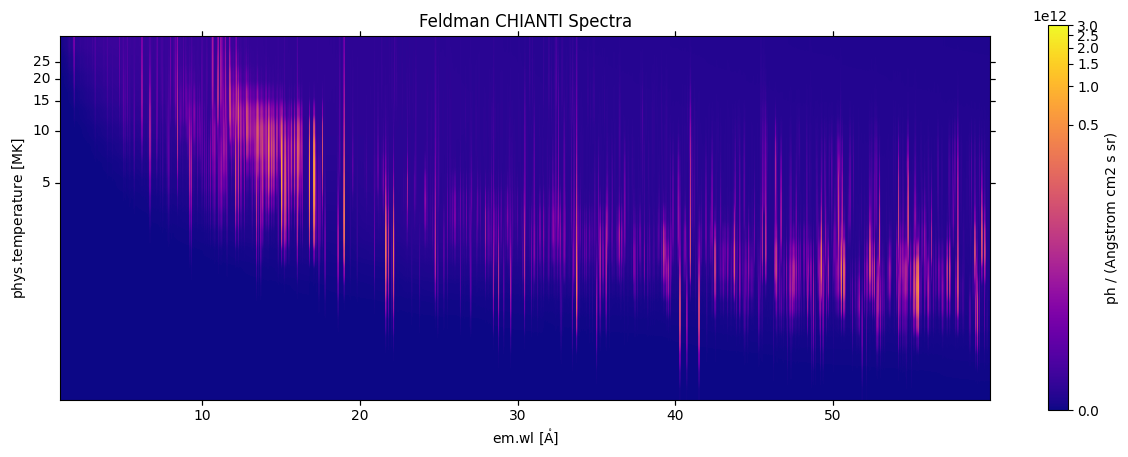

In [127]:
fig = plt.figure(figsize=(15,5))
spectral_table_scaled.plot(aspect=20,
                    axes_units=('MK','Angstrom'),
                    norm=ImageNormalize(vmax=3e12,stretch=LogStretch()),
                    cmap='plasma')
plt.colorbar(label=spectral_table_scaled.unit)
plt.title('Feldman CHIANTI Spectra')

In [141]:
spectral_table_scaled.axis_world_coords(0)[0][i_T].to('MK')

<Quantity 2.51188643 MK>

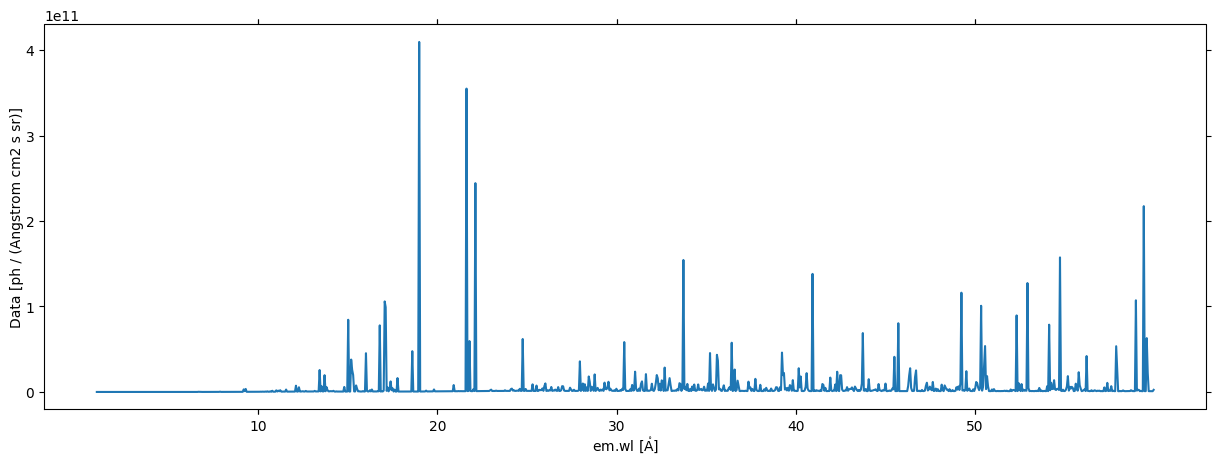

In [139]:
fig = plt.figure(figsize=(15,5))
i_T = np.argmin(np.fabs(spectral_table_scaled.axis_world_coords(0)[0] - 10**6.4*u.K))
ax = spectral_table_scaled[i_T,:].plot()

In [10]:
dem_cube

NDCube
------
Dimensions: [ 30. 350. 350.] pix
Physical Types of Axes: [('phys.temperature',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: 1 / cm5
Data Type: float32

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x12fa4c3d0>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x12fa68dc0>)

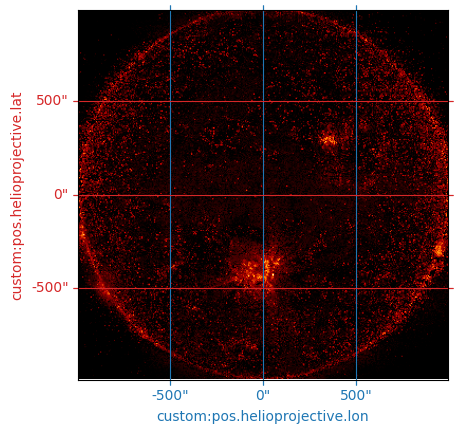

In [11]:
ax = dem_cube[0].plot(cmap='hinodexrt',
                 norm=ImageNormalize(stretch=LogStretch()))
color_lat_lon_axes(ax)

In [9]:
spectral_cube_psa = InstrumentDEM.calculate_intensity(dem_cube, spectral_table, dict(celestial_wcs.to_header()))

In [10]:
spectral_cube_wtb = read_data_cube('moxsi-spectral-cube-ar.fits', hdu=1)

In [11]:
wave0 = 30 * u.Angstrom
wave_index_psa = np.argmin(np.fabs(spectral_cube_psa.axis_world_coords(0)[0] - wave0))
wave_index_wtb = np.argmin(np.fabs(spectral_cube_wtb.axis_world_coords(0)[0] - wave0))

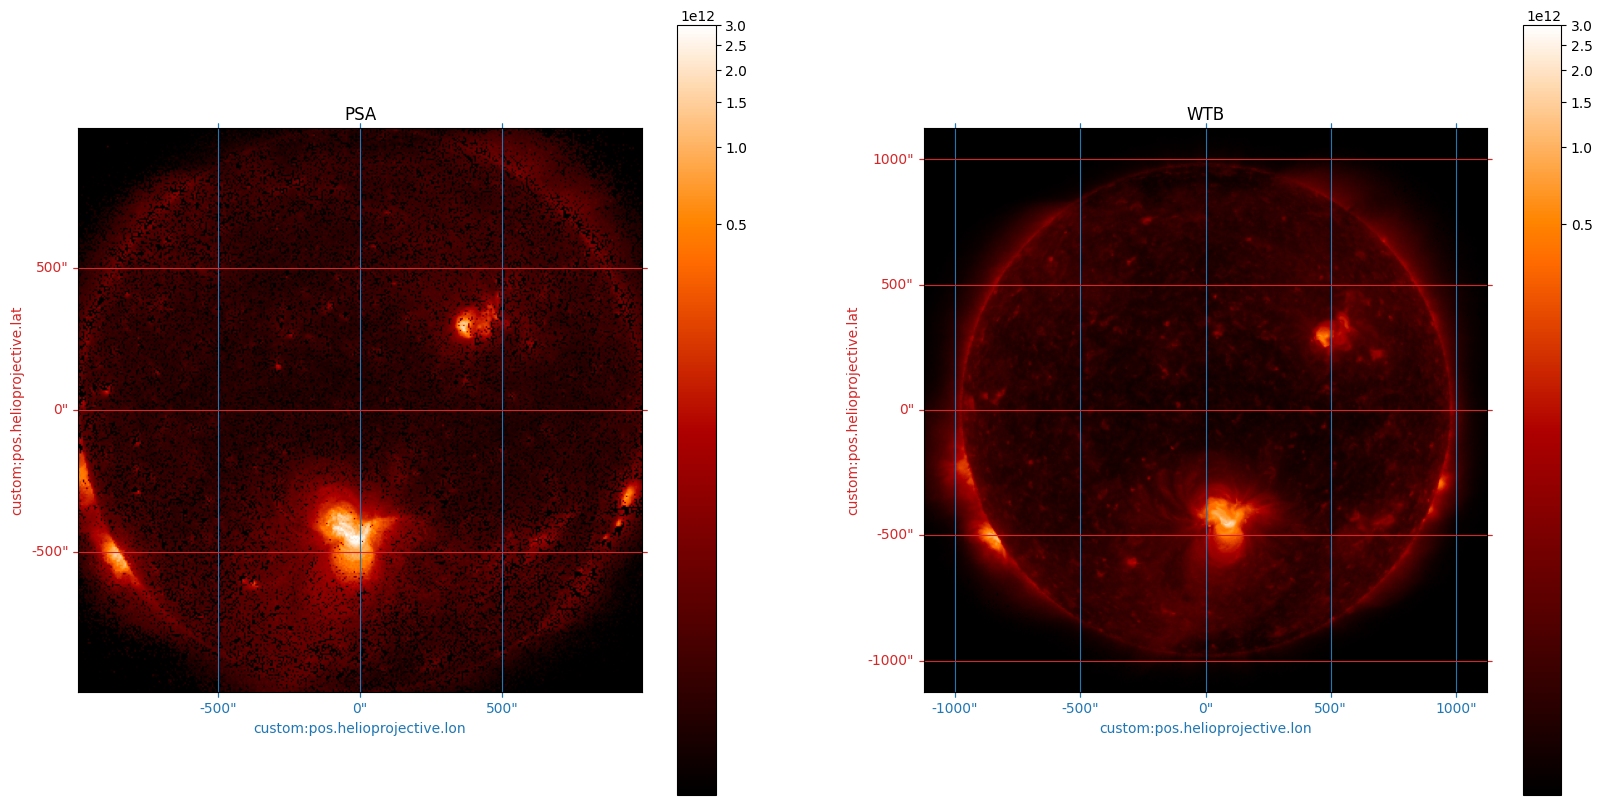

In [12]:
norm = ImageNormalize(vmin=1, vmax=3e12, stretch=LogStretch())
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection=spectral_cube_psa[wave_index_psa])
spectral_cube_psa[wave_index_psa].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (cm2 Angstrom s sr)'
)
color_lat_lon_axes(ax)
ax.set_title('PSA')
plt.colorbar()
ax = fig.add_subplot(122, projection=spectral_cube_wtb[wave_index_wtb])
spectral_cube_wtb[wave_index_wtb].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (cm2 Angstrom s sr)'
)
color_lat_lon_axes(ax)
ax.set_title('WTB')
plt.colorbar()

In [13]:
total_spec_wtb = ndcube.NDCube(data=spectral_cube_wtb.data.sum(axis=0), wcs=spectral_cube_wtb[0].wcs, unit=spectral_cube_wtb.unit)
total_spec_psa = ndcube.NDCube(data=spectral_cube_psa.data.sum(axis=0), wcs=spectral_cube_psa[0].wcs, unit=spectral_cube_psa.unit)

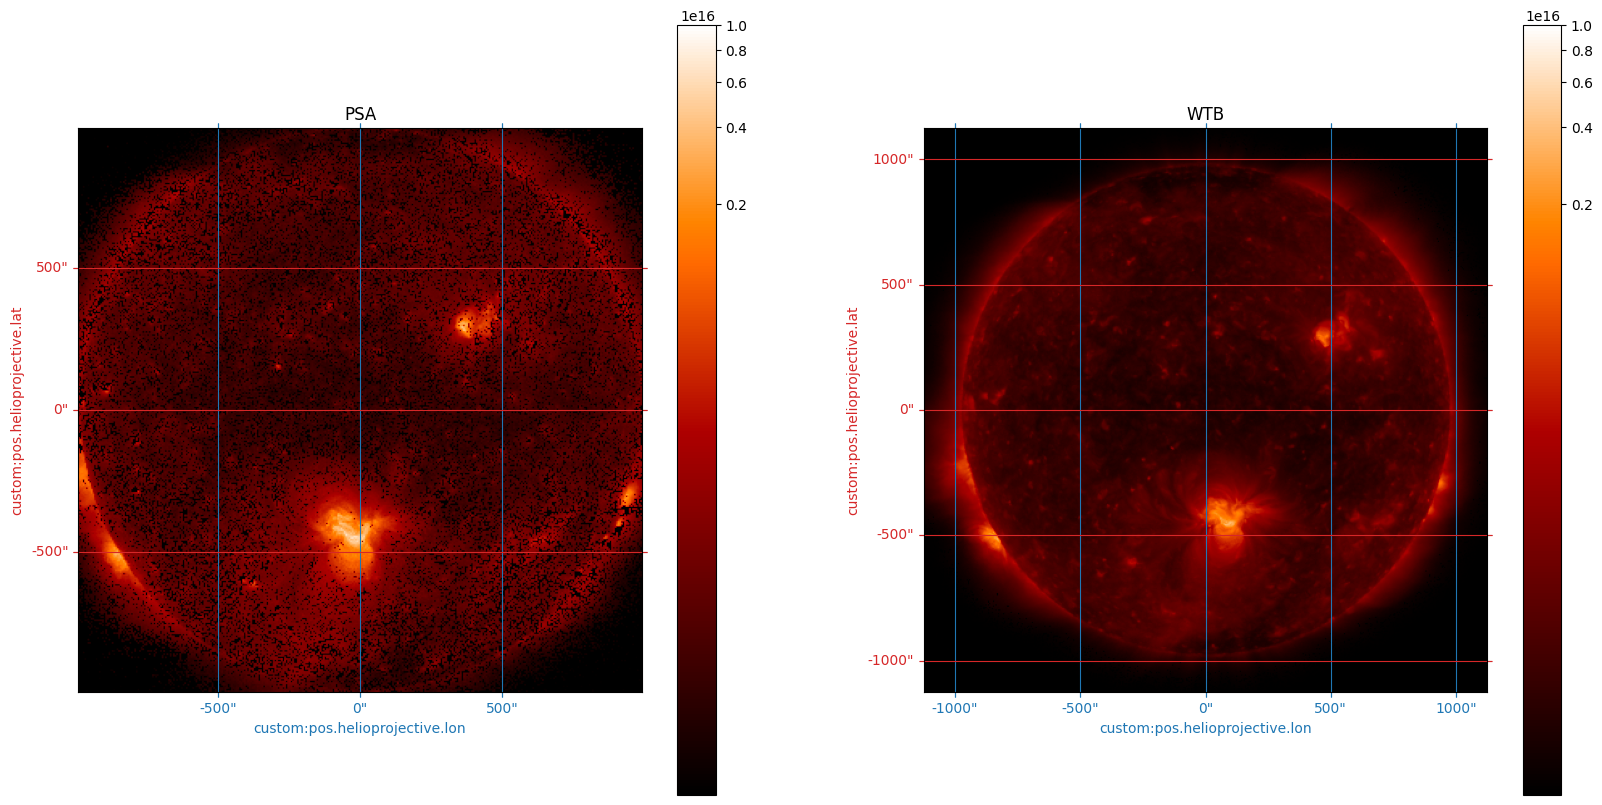

In [14]:
norm = ImageNormalize(vmin=1, vmax=1e16, stretch=LogStretch())
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection=total_spec_psa)
total_spec_psa.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (cm2 Angstrom s sr)'
)
color_lat_lon_axes(ax)
ax.set_title('PSA')
plt.colorbar()
ax = fig.add_subplot(122, projection=total_spec_wtb)
total_spec_wtb.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (cm2 Angstrom s sr)'
)
color_lat_lon_axes(ax)
ax.set_title('WTB')
plt.colorbar()

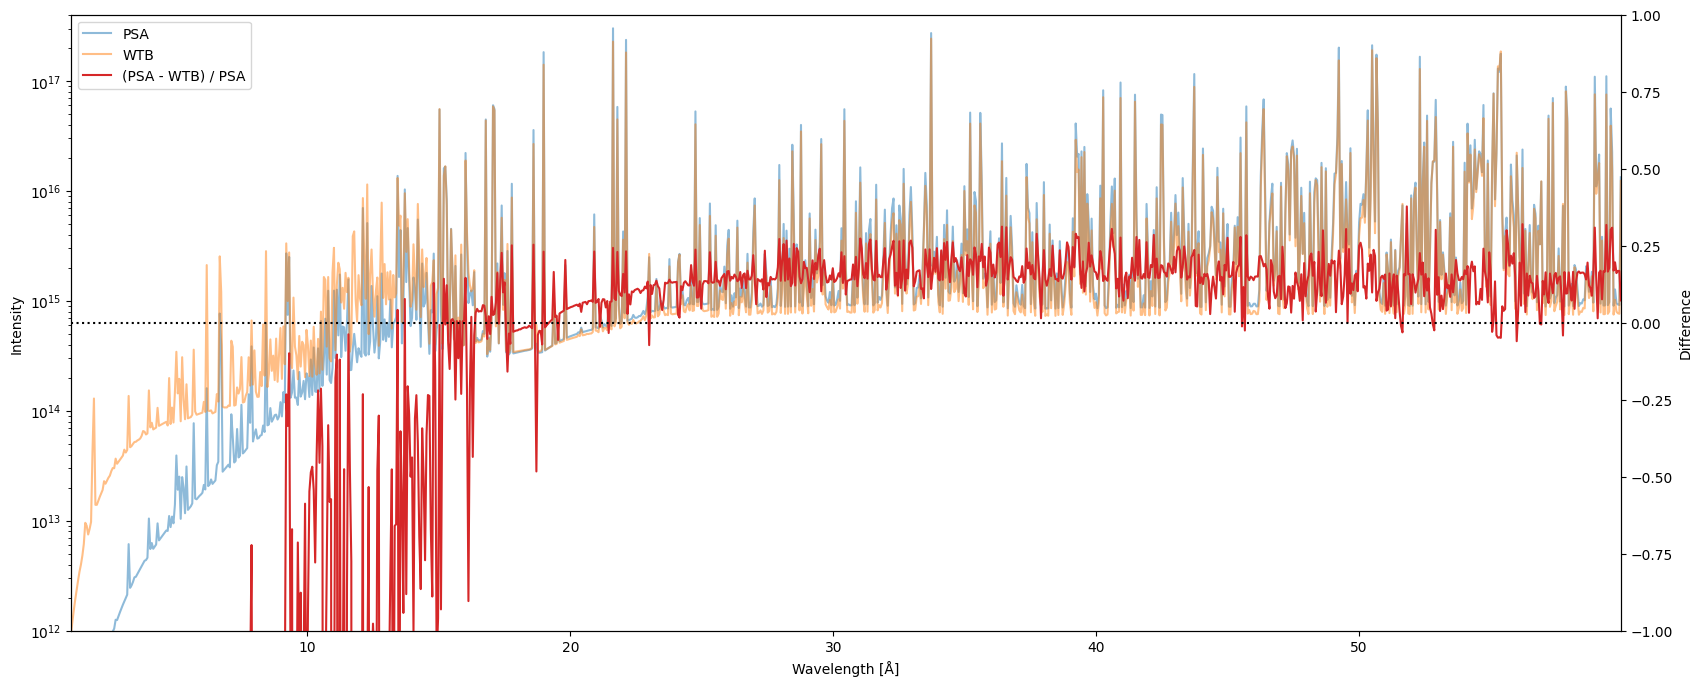

In [60]:
total_spec_wtb_wave = spectral_cube_wtb.data.sum(axis=(1,2))
total_spec_psa_wave = spectral_cube_psa.data.sum(axis=(1,2))
total_spec_wave_interp = np.interp(spectral_cube_psa.axis_world_coords(0)[0], spectral_cube_wtb.axis_world_coords(0)[0],total_spec_wtb_wave)
total_spec_wave_diff = total_spec_psa_wave - total_spec_wave_interp
fig = plt.figure(figsize=(20,8))
# spectra
ax = fig.add_subplot(111)
l1, = ax.plot(spectral_cube_psa.axis_world_coords(0)[0].to('Angstrom'),
         total_spec_psa_wave, label='PSA', alpha=0.5)
l2, = ax.plot(spectral_cube_wtb.axis_world_coords(0)[0].to('Angstrom'), 
         total_spec_wtb_wave, label='WTB', ls='-', alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e12,4e17)
ax.set_ylabel('Intensity')
ax.set_xlabel('Wavelength [Å]')
ax.set_xlim(spectral_cube_psa.axis_world_coords(0)[0][[0,-1]].to_value('Angstrom'))
# difference
ax2 = ax.twinx()
l3, = ax2.plot(spectral_cube_psa.axis_world_coords(0)[0].to('Angstrom'),
         total_spec_wave_diff/total_spec_psa_wave, label='(PSA - WTB) / PSA', color='C3')
ax2.set_ylim(-1,1)
ax2.axhline(y=0,ls=':',color='k')
ax2.set_ylabel('Difference')
# combined legend
lines = [l1,l2,l3]
ax.legend(lines, [l.get_label() for l in lines])

In [15]:
chan = SpectrogramChannel(1, '../../mocksipipeline/data/MOXSI_effarea.genx')

In [16]:
instr_cube_psa = convolve_with_response(spectral_cube_psa, chan, include_gain=False)
instr_cube_wtb = convolve_with_response(spectral_cube_wtb, chan, include_gain=False)

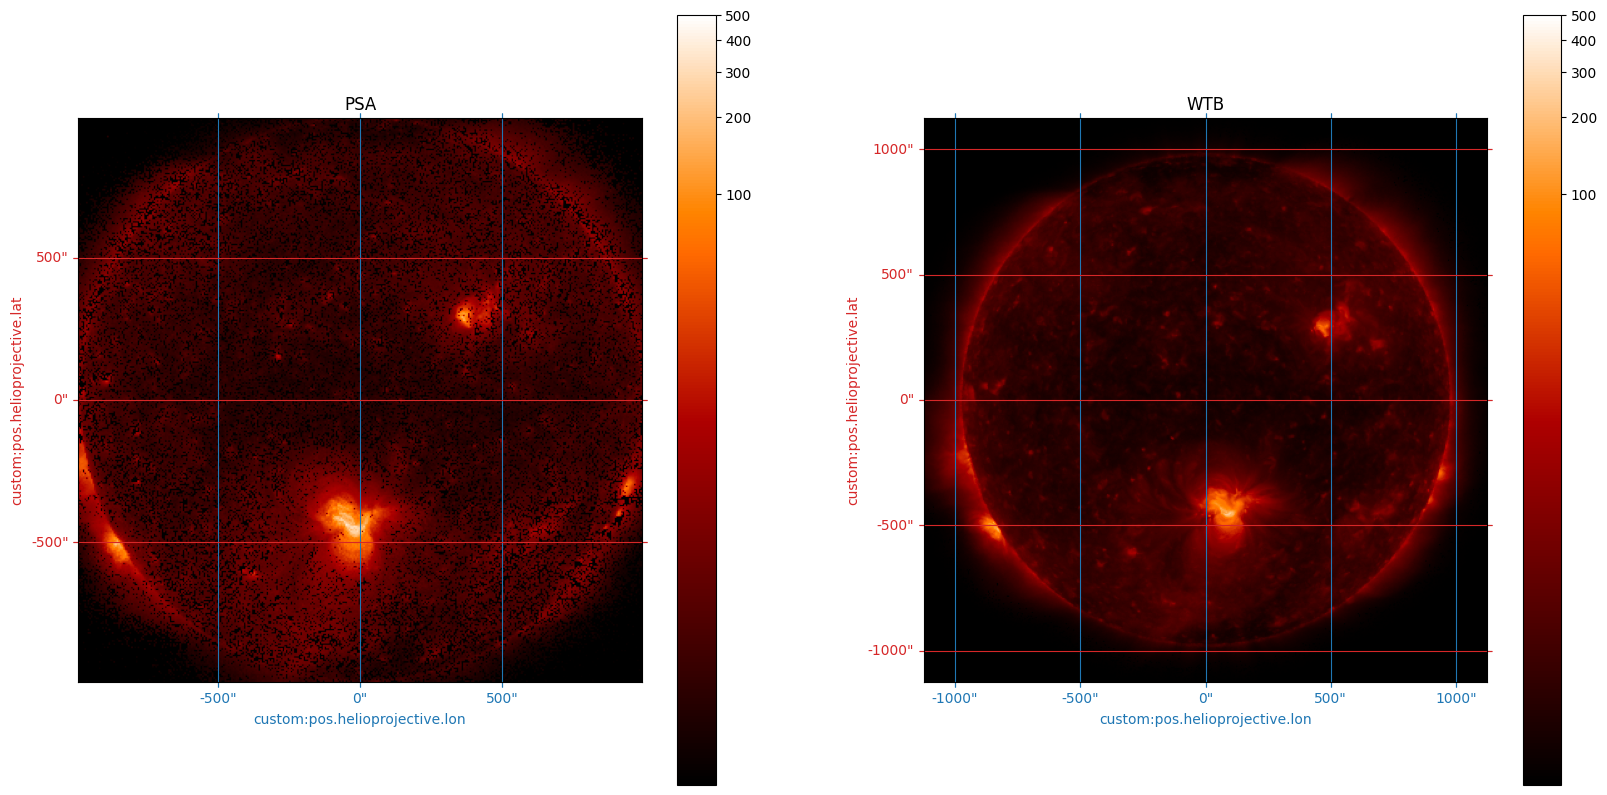

In [21]:
total_instr_wtb = ndcube.NDCube(data=instr_cube_wtb.data.sum(axis=0), wcs=instr_cube_wtb[0].wcs, unit=instr_cube_wtb.unit)
total_instr_psa = ndcube.NDCube(data=instr_cube_psa.data.sum(axis=0), wcs=instr_cube_psa[0].wcs, unit=instr_cube_psa.unit)

norm = ImageNormalize(vmin=1e-3, vmax=500, stretch=LogStretch())
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection=total_instr_psa)
total_instr_psa.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (pix h)'
)
color_lat_lon_axes(ax)
ax.set_title('PSA')
plt.colorbar()
ax = fig.add_subplot(122, projection=total_instr_wtb)
total_instr_wtb.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit='ph / (pix h)'
)
color_lat_lon_axes(ax)
ax.set_title('WTB')
plt.colorbar()

In [114]:
np.s_[:]

slice(None, None, None)

In [113]:
(slice(None),) + np.unravel_index(total_instr_psa.data.argmax(),total_instr_psa.data.shape)

(slice(None, None, None), 97, 166)

In [99]:
chan.plate_scale

<Quantity 7.52978535e-10 sr / pix>

In [97]:
(1*u.arcsec**2).to('sr')

<Quantity 2.35044305e-11 sr>

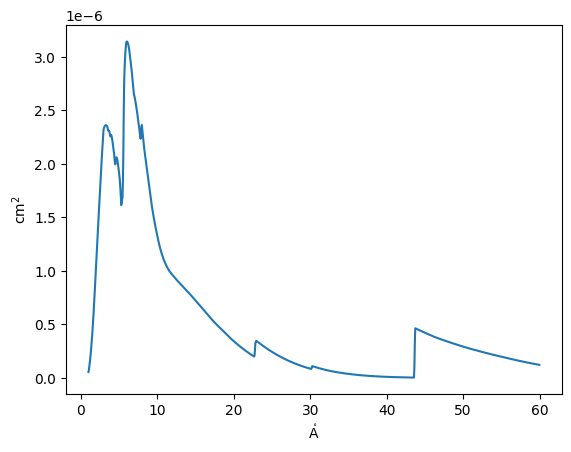

In [101]:
with quantity_support():
    plt.plot(chan.wavelength, chan.effective_area)

[97] [166]


[133] [242]


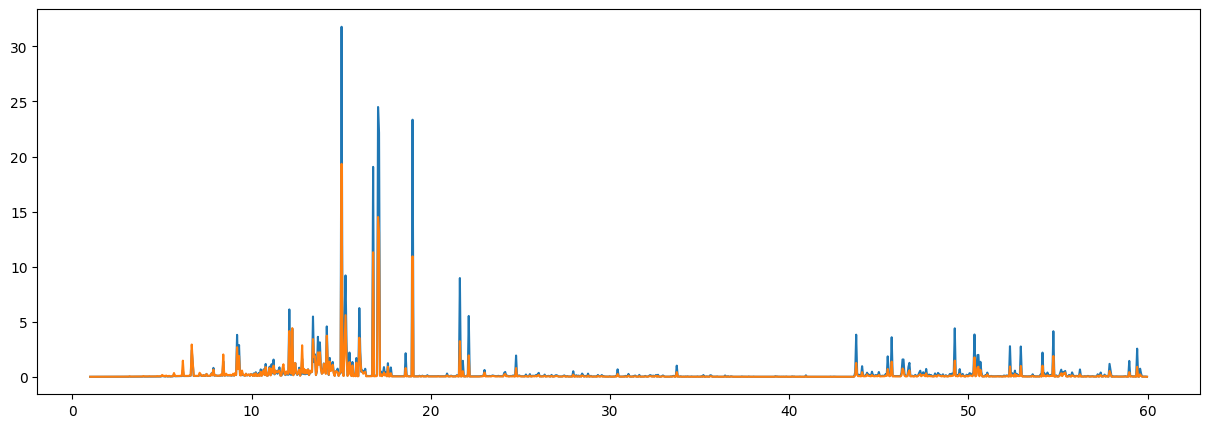

In [22]:
plt.figure(figsize=(15,5))
iy,ix = np.where(total_instr_psa.data == total_instr_psa.data.max())
print(iy,ix)
plt.plot(instr_cube_psa.axis_world_coords(0)[0], u.Quantity(instr_cube_psa.data[:,iy[0],ix[0]], instr_cube_psa.unit).to('ph / (pix h)'))
iy,ix = np.where(total_instr_wtb.data == total_instr_wtb.data.max())
print(iy,ix)
plt.plot(instr_cube_wtb.axis_world_coords(0)[0], u.Quantity(instr_cube_wtb.data[:,iy[0],ix[0]], instr_cube_wtb.unit).to('ph / (pix h)'))
#plt.xlim(14,17)

In [19]:
client = distributed.Client()

2022-09-13 13:46:12,049 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-6qh7ynk2', purging
2022-09-13 13:46:12,049 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-_ad9cevj', purging
2022-09-13 13:46:12,050 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-9v6_0t5f', purging
2022-09-13 13:46:12,050 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-h9qzmlps', purging
2022-09-13 13:46:12,050 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-so3gfgva', purging


In [20]:
overlap_o1_psa = reproject_to_overlappogram(
    instr_cube_psa,
    chan.detector_shape,
    observer=observer,
    reference_pixel=(
        (chan.detector_shape[1] + 1)/2,
        (chan.detector_shape[0] + 1)/2,
        1,
    ) * u.pix,
    reference_coord=(
        0 * u.arcsec,
        0 * u.arcsec,
        chan.wavelength[0],
    ),
    scale=(
        chan.resolution[0],
        chan.resolution[1],
        chan.spectral_resolution,
    ),
    roll_angle=-90*u.deg,
    dispersion_angle=0*u.deg,
    dispersion_axis=0,
    order=chan.spectral_order,
    meta_keys=['CHANNAME'],
    use_dask=True,
    sum_over_lambda=True,
    algorithm='interpolation',
)

In [21]:
overlap_o1_wtb = reproject_to_overlappogram(
    instr_cube_wtb,
    chan.detector_shape,
    observer=observer,
    reference_pixel=(
        (chan.detector_shape[1] + 1)/2,
        (chan.detector_shape[0] + 1)/2,
        1,
    ) * u.pix,
    reference_coord=(
        0 * u.arcsec,
        0 * u.arcsec,
        chan.wavelength[0],
    ),
    scale=(
        chan.resolution[0],
        chan.resolution[1],
        chan.spectral_resolution,
    ),
    roll_angle=-90*u.deg,
    dispersion_angle=0*u.deg,
    dispersion_axis=0,
    order=chan.spectral_order,
    meta_keys=['CHANNAME'],
    use_dask=True,
    sum_over_lambda=True,
    algorithm='interpolation',
)

2022-09-13 14:01:03,099 - bokeh.application.handlers.function - ERROR - '<' not supported between instances of 'NoneType' and 'tuple'
Traceback (most recent call last):
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/distributed/utils.py", line 805, in wrapper
    return func(*args, **kwargs)
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 4006, in graph_doc
    graph = TaskGraph(scheduler, sizing_mode="stretch_both")
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 2077, in __init__
    self.layout = GraphLayout(scheduler)
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/distributed/diagnostics/graph_layout.py", line 41, in __init__
    self.update_graph(
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/distribu

In [42]:
hpc_frame = astropy.wcs.utils.wcs_to_celestial_frame(overlap_o1_wtb.wcs)
blc = SkyCoord(Tx=-275*u.arcsec,Ty=-650*u.arcsec,frame=hpc_frame)
trc = SkyCoord(Tx=275*u.arcsec, Ty=5600*u.arcsec,frame=hpc_frame)
lower = SkyCoord(Tx=[trc.Tx,trc.Tx],Ty=[blc.Ty,trc.Ty],frame=hpc_frame)
upper = SkyCoord(Tx=[blc.Tx,blc.Tx],Ty=[blc.Ty,trc.Ty],frame=hpc_frame)

Text(0.5, 1.0, 'WTB')

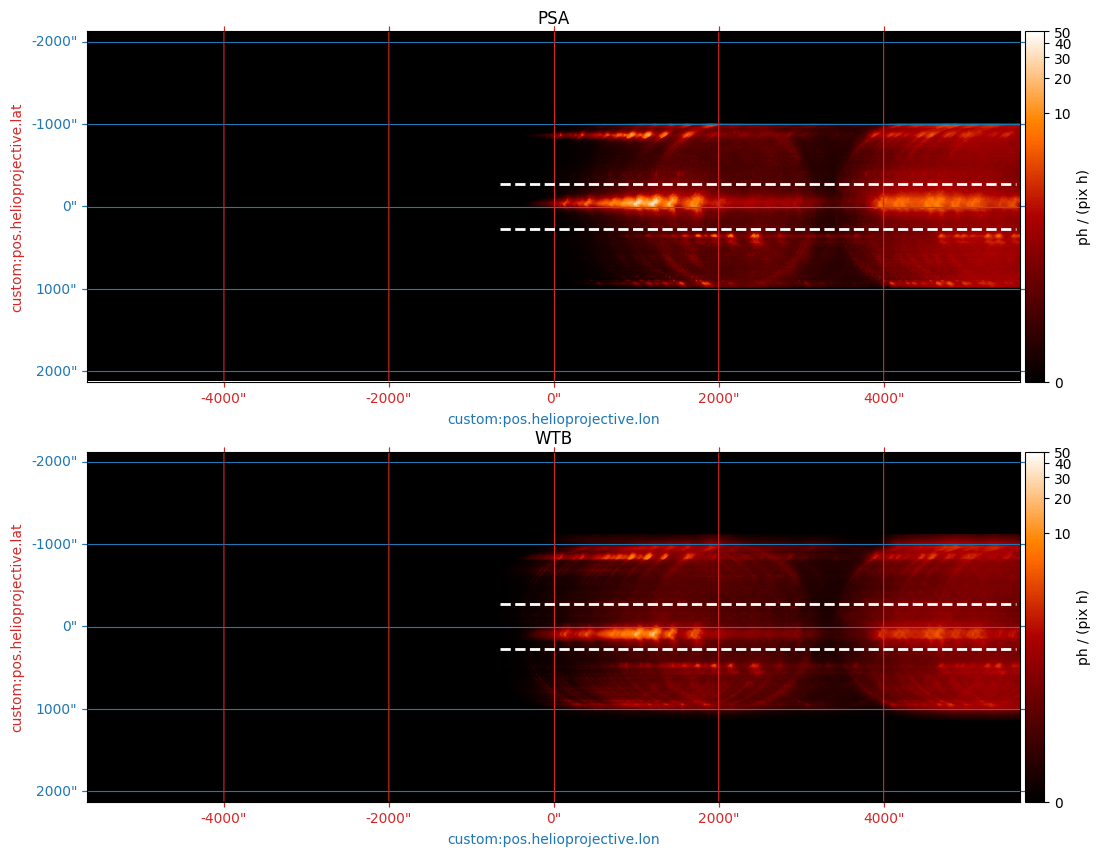

In [77]:
fig = plt.figure(figsize=(15,10))
wave_index = 0
norm = ImageNormalize(vmin=0,vmax=50,stretch=LogStretch())
# PSA
ax = fig.add_subplot(211, projection=overlap_o1_psa[wave_index].wcs)
plot_unit = 'ph / (pix h)'
#vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
#    u.Quantity(total_overlap[wave_index].data, total_overlap.unit).to_value(plot_unit),
#)
overlap_o1_psa[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit=plot_unit
)
ax.plot_coord(lower, ls='--', color='w', lw=2)
ax.plot_coord(upper, ls='--', color='w', lw=2)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)
ax.set_title('PSA')
# WTB
ax = fig.add_subplot(212, projection=overlap_o1_wtb[wave_index].wcs)
overlap_o1_wtb[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit=plot_unit
)
ax.plot_coord(lower, ls='--', color='w', lw=2)
ax.plot_coord(upper, ls='--', color='w', lw=2)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)
ax.set_title('WTB')

In [46]:
overlap_o1_psa_crop = overlap_o1_psa[wave_index].crop(blc, trc)
overlap_o1_wtb_crop = overlap_o1_wtb[wave_index].crop(blc, trc)

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x16e907d30>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x16e9dc8b0>)

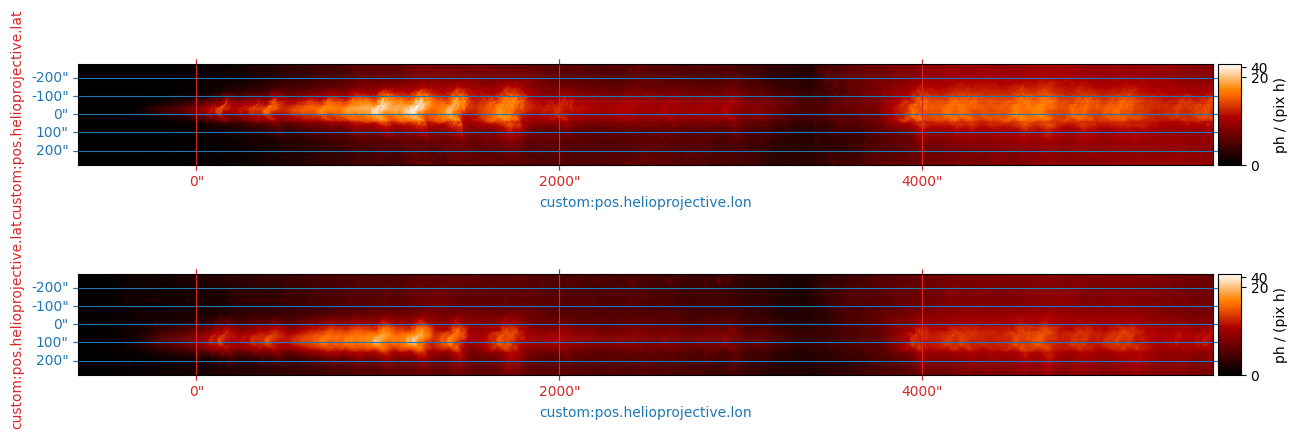

In [47]:
fig = plt.figure(figsize=(15,5))
# PSA
ax = fig.add_subplot(211, projection=overlap_o1_psa_crop.wcs)
overlap_o1_psa_crop.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit=plot_unit
)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)
# WTB
ax = fig.add_subplot(212, projection=overlap_o1_wtb_crop.wcs)
overlap_o1_wtb_crop.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=norm,
    data_unit=plot_unit
)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)

In [59]:
pix_x_cut = np.linspace(0, overlap_o1_psa_crop.data.shape[1]-1, overlap_o1_psa_crop.data.shape[1])
coord_cut = overlap_o1_psa_crop.wcs.pixel_to_world(pix_x_cut, (overlap_o1_psa_crop.data.shape[0]-1)/2)

(-1.0, 1.0)

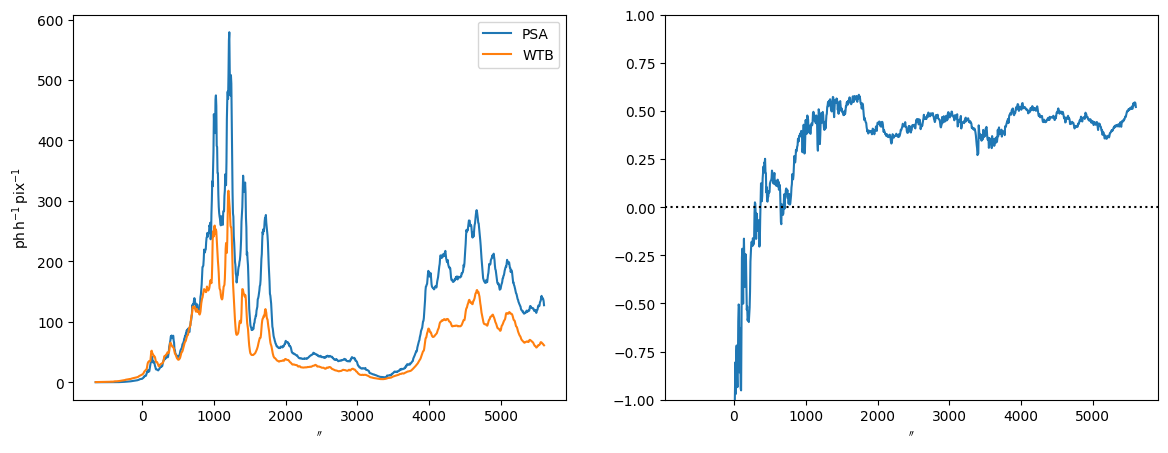

In [75]:
ar_sum_psa = u.Quantity(overlap_o1_psa_crop.data.sum(axis=0), overlap_o1_psa_crop.unit)
ar_sum_wtb = u.Quantity(overlap_o1_wtb_crop.data.sum(axis=0), overlap_o1_wtb_crop.unit)

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
with quantity_support():
    ax.plot(coord_cut.Ty, ar_sum_psa.to('ph / pix / h'), label='PSA')
    ax.plot(coord_cut.Ty, ar_sum_wtb, label='WTB')
#plt.yscale('log')
ax.legend()
ax = fig.add_subplot(122)
with quantity_support():
    ax.plot(coord_cut.Ty, (ar_sum_psa - ar_sum_wtb)/ar_sum_psa)
ax.axhline(y=0,ls=':',color='k')
ax.set_ylim(-1,1)